In [1]:
%run 'Data Cleaning.ipynb'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Id                  3000000 non-null  object 
 1   Title               2999792 non-null  object 
 2   Price               481171 non-null   float64
 3   User_id             2438213 non-null  object 
 4   profileName         2438095 non-null  object 
 5   review/helpfulness  3000000 non-null  object 
 6   review/score        3000000 non-null  float64
 7   review/time         3000000 non-null  int64  
 8   review/summary      2999593 non-null  object 
 9   review/text         2999992 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id  

In [2]:
import torch
import torch.nn as nn

class CollabFiltModel(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        return (user_emb * item_emb).sum(1)


In [3]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

cleaned_df['User_id'] = user_encoder.fit_transform(cleaned_df['User_id'])
cleaned_df['Title'] = item_encoder.fit_transform(cleaned_df['Title'])

class ReviewDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.users = torch.tensor(users, dtype=torch.int64)
        self.items = torch.tensor(items, dtype=torch.int64)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]
    
    def __len__(self):
        return len(self.ratings)

dataset = ReviewDataset(cleaned_df['User_id'].values,
                        cleaned_df['Title'].values,
                        cleaned_df['review/score'].values)

dataloader = DataLoader(dataset, batch_size=512, shuffle=True)


/Users/wesleydickens/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/wesleydickens/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/wesleydickens/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/wesleydickens/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CollabFiltModel(num_users=cleaned_df['User_id'].nunique(),
                        num_items=cleaned_df['Title'].nunique()).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_loss_dict = {}
for epoch in range(10):
    for users, items, ratings in dataloader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    epoch_loss_dict[epoch] = loss.item()

Epoch 1, Loss: 73.8791275024414
Epoch 2, Loss: 40.05559158325195
Epoch 3, Loss: 17.023601531982422
Epoch 4, Loss: 9.332221031188965
Epoch 5, Loss: 6.376220703125
Epoch 6, Loss: 3.461580276489258
Epoch 7, Loss: 3.177886486053467
Epoch 8, Loss: 3.0396687984466553
Epoch 9, Loss: 2.400233268737793
Epoch 10, Loss: 1.823348045349121


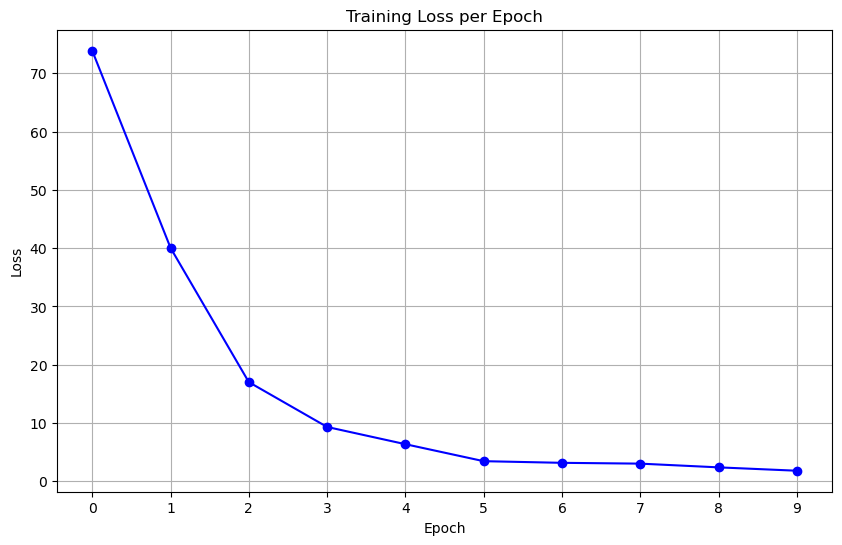

In [5]:
import matplotlib.pyplot as plt

epochs = list(epoch_loss_dict.keys())
losses = list(epoch_loss_dict.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [6]:
def recommend_items_for_user(model, user_id, user_encoder, item_encoder, num_recommendations=5):
    # Set model to evaluation mode
    model.eval()
    
    # Encode the user ID
    encoded_user_id = user_encoder.transform([user_id])
    
    # Create a tensor for the user ID
    user_tensor = torch.tensor(encoded_user_id, dtype=torch.int64).to(device)
    
    # Predict scores for all items for this user
    all_items = torch.tensor(range(len(item_encoder.classes_)), dtype=torch.int64).to(device)
    user = user_tensor.repeat(len(all_items))
    predictions = model(user, all_items).detach().cpu().numpy()
    # Get the top N recommendations; argsort returns indices of sorted array
    top_indices = predictions.argsort()[-num_recommendations:][::-1]
    # Decode the recommended item IDs
    recommended_items = item_encoder.inverse_transform(top_indices)
    top_ratings = predictions[top_indices]
    print(top_ratings)
    return recommended_items

user_id_to_recommend = 'AVCGYZL8FQQTD'  # Example user ID
recommended_items = recommend_items_for_user(model, user_id_to_recommend, user_encoder, item_encoder)
print("Recommended Items:", recommended_items)


[45.54682  42.097397 41.50647  39.671608 39.62702 ]
Recommended Items: ['Accounting and Recordkeeping Made Easy for the Self-Employed'
 'Calligraphic Ornaments CD-ROM and Book (Dover Electronic Clip Art)'
 'Prom Night'
 'NYC Ballet Workout: Fifty Stretches And Exercises Anyone Can Do For A Strong, Graceful, And Sculpted Body'
 'Edgar Cayce on Healing Foods for Body, Mind, and Soul']


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)


In [8]:
train_dataset = ReviewDataset(train_df['User_id'].values, train_df['Title'].values, train_df['review/score'].values)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ReviewDataset(test_df['User_id'].values, test_df['Title'].values, test_df['review/score'].values)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


RMSE: 1.3729840517044067
MAE: 1.091171658376058


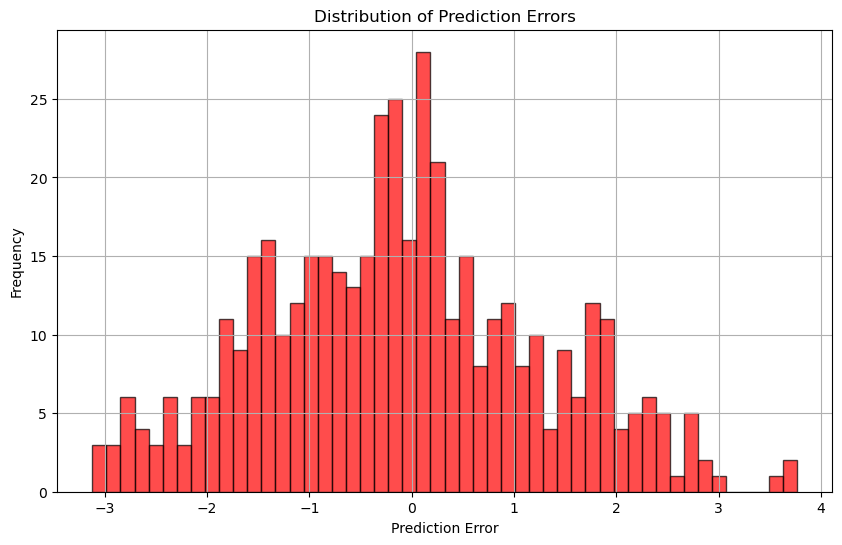

In [10]:
model.eval()
total_squared_error = 0.0
total_absolute_error = 0.0
total_count = 0

with torch.no_grad():
    for users, items, ratings in test_dataloader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        error = predictions - ratings
        # Squared error for RMSE
        squared_error = error ** 2
        total_squared_error += squared_error.sum().item()
        # Absolute error for MAE
        absolute_error = torch.abs(error)
        total_absolute_error += absolute_error.sum().item()
        
        total_count += ratings.size(0)

# Calculate mean squared error and RMSE
mse = total_squared_error / total_count
rmse = torch.sqrt(torch.tensor(mse))

# Calculate mean absolute error
mae = total_absolute_error / total_count

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

plt.figure(figsize=(10, 6))
plt.hist(error.cpu().numpy(), bins=50, alpha=0.7, color='r', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [11]:
# Save the model state dictionary
torch.save(model.state_dict(), 'Model Files/collab_filt_model_state_dict.pth')

# Save the encoders
import joblib
joblib.dump(user_encoder, 'Model Files/user_encoder.joblib')
joblib.dump(item_encoder, 'Model Files/item_encoder.joblib')

cleaned_df.to_csv('Model Files/cleaned_df.csv')
